In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install keras-cv

In [ ]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv


BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE # 데이터 로딩과 전처리 과정을 최적화하는데 사용하는 설정, 실행 환경에 맞게 자동으로 적절한 스레드 수나 버퍼 크기를 설정
# 즉, 데이터 파이프라인의 성능을 자동으로 튜닝할 수 있어, 전체 모델의 훈련 속도와 효율성을 개선하는 데 도움을 줌.

Using TensorFlow backend


# <span style="color:#e74c3c;"> </span> Preprocessing

In [ ]:
# a function for converting txt file to list
# 이미지 파일의 경로와 텍스트 파일의 경로를 입력받아 텍스트 파일에 있는 주석을 읽어 해당 이미지 내 객체들의 바운딩 박스와 클래스 라벨을 추출하는 역할
def parse_txt_annot(img_path, txt_path): # 이미지 파일 경로, 텍스트 파일 경로
    img = cv2.imread(img_path) # 이미지 로드
    w = int(img.shape[0]) # 이미지 너비와 높이 추출
    h = int(img.shape[1])

    file_label = open(txt_path, "r") # 텍스트 파일을 읽기 모드로 켜고
    lines = file_label.read().split('\n')  # 파일 전체 내용을 읽고 개행 문자를 구분자로 사용하여 라인별로 분리

    boxes = [] # 객체의 위치를 나타내는 좌표 저장
    classes = [] # 각 객체의 클래스 저장

    if lines[0] == '': # 첫번째 줄이 비어 있으면 아무 객체가 없어 이미지 경로와 빈 클래스 및 박스 리스트 반환
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])
            # 각 라인을 순회하며 객체 데이터를 처리, 각 라인에서 클래스 번호와 바운딩 박스 좌표, 너비, 높이 추출
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
            # 바운딩 박스 계산, 추출된 값을 사용해 바운딩 박스의 실제 픽셀 좌표 계산
            xmin = int((x1*w) - (w1*w)/2.0) # 좌측 상단 모서리
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0) # 우측 하단 모서리
            ymax = int((y1*h) + (h1*h)/2.0)

            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)
    # 결과 반환, 이미지 경로, 클래스 리스트, 바운딩 박스 리스트 반환.
    return img_path, classes, boxes


# a function for creating file paths list
# 주어진 디렉터리 경로에 있는 모든 파일들의 전체 경로 목록을 생성
def create_paths_list(path): # path 파일들이 저장된 디렉터리 경로
    full_path = [] # 디렉터리 내 모든 파일의 전체 경로를 저장
    images = sorted(os.listdir(path)) # 알파벳순으로 정렬, 주어진 경로에 있는 파일들의 목록을 가져옴

    for i in images:
        full_path.append(os.path.join(path, i)) # 전체 파일 경로를 생성, 리스트에 추가

    return full_path # 생성된 전체 경로를 반환


class_ids = ['Acne'] # 클래스 식별자 리스트
class_mapping = {0: 'Acne'} # 정수 인덱스르르 클래스 이름에 매핑, 딕셔너리 이용. 0 -> 여드름으로 인식

In [ ]:
# a function for creating a dict format of files
# 이미지 파일 경로와 주석 파일 경로를 입력 받아 각 이미지 파일에 대한 주석 정보를 파싱하고 텐서플로의 형태로 변환하는 함수
# 딕셔너리 형식의 파일 형태를 만드는 함수
def creating_files(img_files_paths, annot_files_paths):

    img_files = create_paths_list(img_files_paths) # 이미지 파일들이 저장된 디렉터리 경로, 앞서 언급된 함수를 호출해 전체 경로 리스트 생성
    annot_files = create_paths_list(annot_files_paths) # 주석 파일이 저장된 디렉터리 경로

    image_paths = [] # 이미지 경로
    bbox = [] # 바운딩 박스
    classes = [] # 클래스 저장

    for i in range(0,len(img_files)): # 이미지 파일만큼 반복
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i]) # 이미지 경로, 클래스, 바운딩 박스 정보를 추출(파싱)
        # 앞서 초기화한 리스트에 추가
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    # 텐서플로우 ragged텐서로 변환. 앞서 저장된 리스트를 ragged텐서로 변환 -> 비정형 데이터를 다루기 위함
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    # 변환된 ragged텐서 형태의 이미지 경로, 클래스, 바운딩 박스 정보 반환
    return image_paths, classes, bbox

In [ ]:
# applying functions
# 앞서 선언한 creating_files 함수를 사용해 훈련, 검증, 테스트 데이터 셋 생성
# 이미지 경로, 클래스, 바운딩 박스 정보 로드
train_img_paths, train_classes, train_bboxes = creating_files('/content/drive/MyDrive/acne_detection/train/images',
                                                              '/content/drive/MyDrive/acne_detection/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('/content/drive/MyDrive/acne_detection/valid/images',
                                                             '/content/drive/MyDrive/acne_detection/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('/content/drive/MyDrive/acne_detection/test/images',
                                                          '/content/drive/MyDrive/acne_detection/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [ ]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path) # 이미지 읽기
    img = tf.image.decode_jpeg(img, channels = 3) # jpeg파일로 디코딩하고 채널을 3개로 설정
    img = tf.cast(img, tf.float32)  # 이미지를 32비트 부동 소수점 형식으로 변환. 모델 입력전이라 이렇게 함

    return img

# 이미지 크기를 변경하는데 사용됨. 이미지의 크기를 다양하게 조절할 수 있도록 함. 바운딩 박스도 조정
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640), # 640 * 640으로 설정
    scale_factor=(0.8, 1.25), # 0.8배에서 1.25배 범위 내에서 임의로 크기를 조정
    bounding_box_format="xyxy") # 바운딩 박스가 좌측 상단, 우측 하단의 x, y좌표로 정의 되어 있음

# loading dataset
# 이미지 파일의 경로, 해당 이미지에 대한 클래스 정보, 바운딩 박스 정보를 입력으로 해 이를 딕셔너리 형태로 묶어 반환
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths) # 이미지를 로드하고 전처리 함

    # 바운딩 박스 딕셔너리 생성. 클래스와 바운딩 박스 정보를 각각 텐서로 변환해 딕셔너리에 저장
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32), # 클래스 정보를 부동 소수점 형태로 변환
        "boxes": bbox } # 바운딩 박스 정보를 그대로 사용

    return {"images": img, "bounding_boxes": bounding_boxes} # 전처리된 이미지와 바운딩 박스 정보를 포함한 딕셔너리 반환

# 앞선 함수에서 생성된 딕셔너리를 입력받아, 이미지 데이터와 바운딩 박스 정보를 튜플 형식으로 변환
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [ ]:
# Creating dataset loaders and tf.datasets
# 데이터 셋을 위한 로더와 데이터 파이프라인으로 구성

# 학습 데이터 로더 구성
# 각 데이터셋의 이미지 경로, 클래스, 바운딩 박스 정보로부터 텐서 슬라이스 데이터셋을 생성. 각 요소를 개별적으로 처리할 수 있음
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
# 데이터셋 파이프라인 구성
# 1. 데이터 로딩 및 전처리: load_ds함수를 사용해 각 이미지를 로드하고, 해당 데이터를 딕셔너리 형태로 전처리 AUTO는 자동으로 적절한 수의 병렬 처리를 결정하도록 함
# 2. 데이터 셔플링과 배치 처리: 데이터 순서를 무작위로 섞음(학습 데이터만). 16의 배치사이즈로 각 배치 내의 데이터 포인트가 다른 길이를 가질 수 있게 함. 마지막 배치가 배치크기보다 작으면 버림
# 3. 이미지 재조정: 각 이미지 크기를 재조정하여 입력받는 이미지 크기를 일정하게 유지시킴
# 4. 데이터 포맷변환: 데이터를 딕셔너리 형태에서 튜플 형태로 변환
# 5. 데이터 프리페칭: 데이터 로딩을 비동기적으로 수행하여 모델 훈련 시 GPU가 다음 데이터 배치를 기다리지 않고 계속 훈련할 수 있도록 함.
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [ ]:
# a function to visualize samples from a dataset
# 시각화
# 데이터 셋에서 한 배치만 가져와 시각화
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1))) # 하나의 배치를 가져와 해당 배치를 추출함
    images, bounding_boxes = inputs[0], inputs[1] # 추출된 데이터에서 이미지와 바운딩 박스 정보를 불러옴

    # 이미지에 바운딩 박스와 클래스 레이블을 표시
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 6,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43)) # 바운딩 박스의 색상

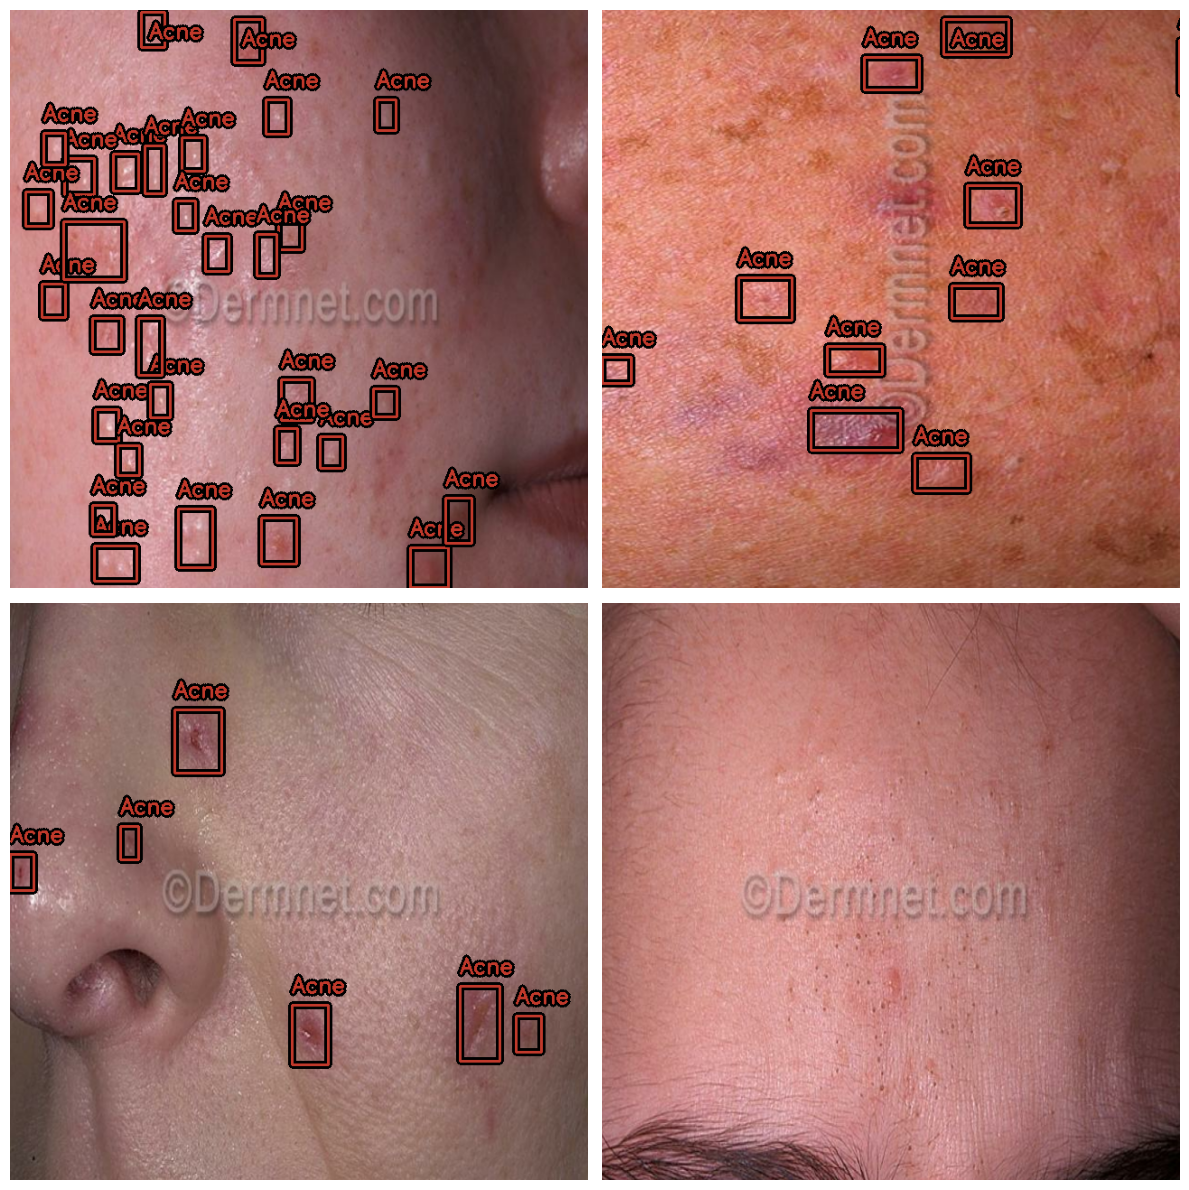

In [ ]:
# examples images and annotations from training daatset
#inputs: 데이터셋 객체. 이 함수는 데이터셋에서 한 배치만 가져옵니다 (inputs.take(1)).
# value_range: 이미지 픽셀 값의 범위. 예를 들어, [0, 255]은 픽셀 값이 0부터 255까지인 일반적인 8비트 이미지를 의미합니다.
# rows, cols: 시각화할 이미지 갤러리의 행과 열 수.
# bounding_box_format: 바운딩 박스의 데이터 형식을 지정합니다. 'xyxy'는 좌측 상단과 우측 하단의 좌표를 사용합니다.
# class_mapping: 각 클래스 ID에 해당하는 이름을 매핑하는 사전. {0: 'Acne'}는 클래스 ID 0을 "Acne"라는 이름으로 표시합니다.
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

In [ ]:
# creating mirrored strategy
# mirroredstrategy초기화 싱글  머신 환경에서 모델 훈련을 가속화하기 위해 사용
# 효율적으로 대규모 모델을 바르게 훈련할 수 있도록 함
stg = tf.distribute.MirroredStrategy()

In [ ]:
# creating yolo backbone

with stg.scope(): # 모델 관련 컴포넌트가 mirroedstrategy를 사용해 여러 gpu에 걸쳐 동기화되게 설정
    # 모델 백본 생성 yolov8의 사전 설정된 작은 크기의 백본 설정, 입력 이미지의 자동 리스케일링 활성화
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)
    # yolov8 모델설정. 생성된 백본과 추가 설정을 사용해 객체 탐지 모델 초기화. 클래스 수는 class_mapping 딕셔너리 길이를 기반. 바운딩 박스 포맷은 xyxy
    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                                  bounding_box_format = "xyxy", backbone = backbone, fpn_depth = 5)

    # 옵티마이저 및 콜백 설정: AdamW사용
    optimizer = AdamW(learning_rate=0.0007, weight_decay=0.0009, global_clipnorm = 10.0)
    # 모델 훈련과정에서 성능을 모니터링하고 조정하는 콜백 설정. 가중치 저장 및 학습률 조정, 조기 종료
    my_callbacks = [ModelCheckpoint('/content/drive/MyDrive/yolo_model/yolo_acne_detection.h5', monitor = 'val_loss',save_best_only = True, save_weights_only = True),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=8, verbose=0, min_delta=0.001),
                    EarlyStopping(monitor='val_loss', patience=20)]

    # 모델 컴파일, 이진 크로스엔트로피 사용, 바운딩 박스 손실로는 CIoU사용
    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

# <span style="color:#e74c3c;"> Training </span>

In [ ]:
# 모델 학습
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 140, callbacks = my_callbacks)

Epoch 1/140
51/51 [==============================] - 57s 211ms/step - loss: 87.1697 - box_loss: 4.7661 - class_loss: 82.4036 - val_loss: 23.9596 - val_box_loss: 4.9439 - val_class_loss: 19.0157 - lr: 7.0000e-04
Epoch 2/140
51/51 [==============================] - 8s 145ms/step - loss: 27.5469 - box_loss: 3.9054 - class_loss: 23.6415 - val_loss: 27.9294 - val_box_loss: 3.4979 - val_class_loss: 24.4315 - lr: 7.0000e-04
Epoch 3/140
51/51 [==============================] - 10s 175ms/step - loss: 14.3347 - box_loss: 3.6985 - class_loss: 10.6362 - val_loss: 13.1613 - val_box_loss: 3.5737 - val_class_loss: 9.5876 - lr: 7.0000e-04
Epoch 4/140
51/51 [==============================] - 10s 173ms/step - loss: 9.4043 - box_loss: 3.6315 - class_loss: 5.7729 - val_loss: 8.3240 - val_box_loss: 3.5099 - val_class_loss: 4.8141 - lr: 7.0000e-04
Epoch 5/140
51/51 [==============================] - 9s 156ms/step - loss: 7.6677 - box_loss: 3.5856 - class_loss: 4.0820 - val_loss: 7.5529 - val_box_loss: 3.575

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


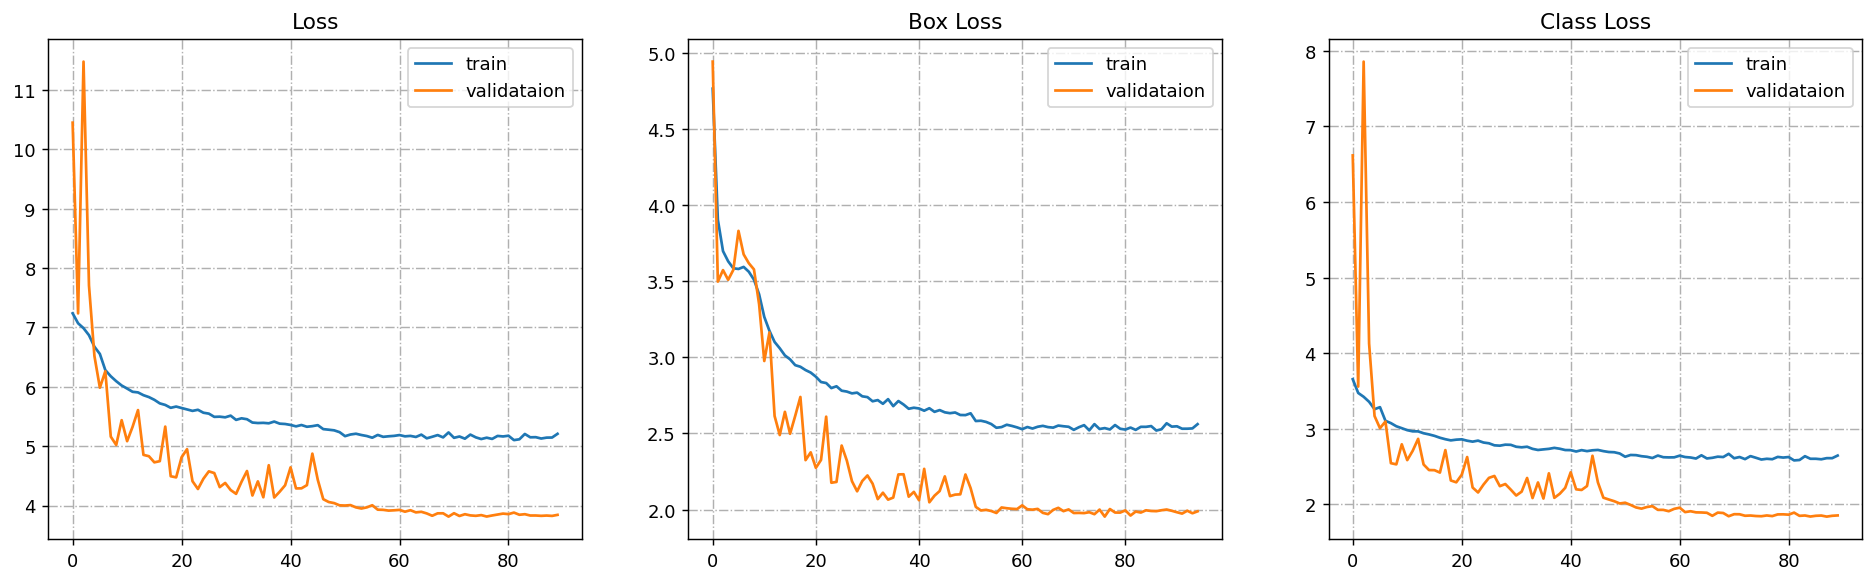

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][5:])
axs[0].plot(hist.history['val_loss'][5:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][5:])
axs[2].plot(hist.history['val_class_loss'][5:])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
# 테스트 데이터셋에 대한 모델의 성능을 평가
YOLOV8_model.evaluate(test_dataset)

3/3 [==============================] - 2s 49ms/step - loss: 3.9238 - box_loss: 2.1051 - class_loss: 1.8186


[3.9237797260284424, 2.1051485538482666, 1.8186310529708862]

In [ ]:
# 모델을 사용해 예측을 수행한 다음 실제 바운딩 박스와 예측된 바운딩 박스를 함께 시각화 하는 함수
# 입력: 예측을 수행할 모델, 이미지와 실제 바운딩 박스 정보가 포함된 데이터셋, 바운딩 박스 형식 지정
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1))) # 데이터셋에서 한 배치의 이미지와 실제 바운딩 박스 정보를 추출

    y_pred = model.predict(images, verbose = 0) # 모델 예측 수행
    y_pred = keras_cv.bounding_box.to_ragged(y_pred) # 예측 포맷 변환. 모델 출력을 바운딩 박스 데이터로 변환

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255), # 이미지 데이터의 값의 범위
        bounding_box_format=bounding_box_format, # 바운딩 박스의 형식
        y_true=y_true, # 실제 바운딩 박스
        y_pred=y_pred, # 예측 바운딩 박스
        true_color = (192, 57, 43), # 실제 바운딩 박스 색깔
        pred_color=(255, 235, 59), # 예측 바운딩 박스 색깔
        scale = 8, # 이미지 스케일링 인자
        font_scale = 0.8, # 텍스트, 선 두께 및 dpi 설정
        line_thickness=2,
        dpi = 100,
        rows=2, # 갤러리의 행과 열의 수
        cols=2,
        show=True, # 시각화 결과 표시 여부
        class_mapping=class_mapping, # 클래스 ID와 이름 매핑
    )

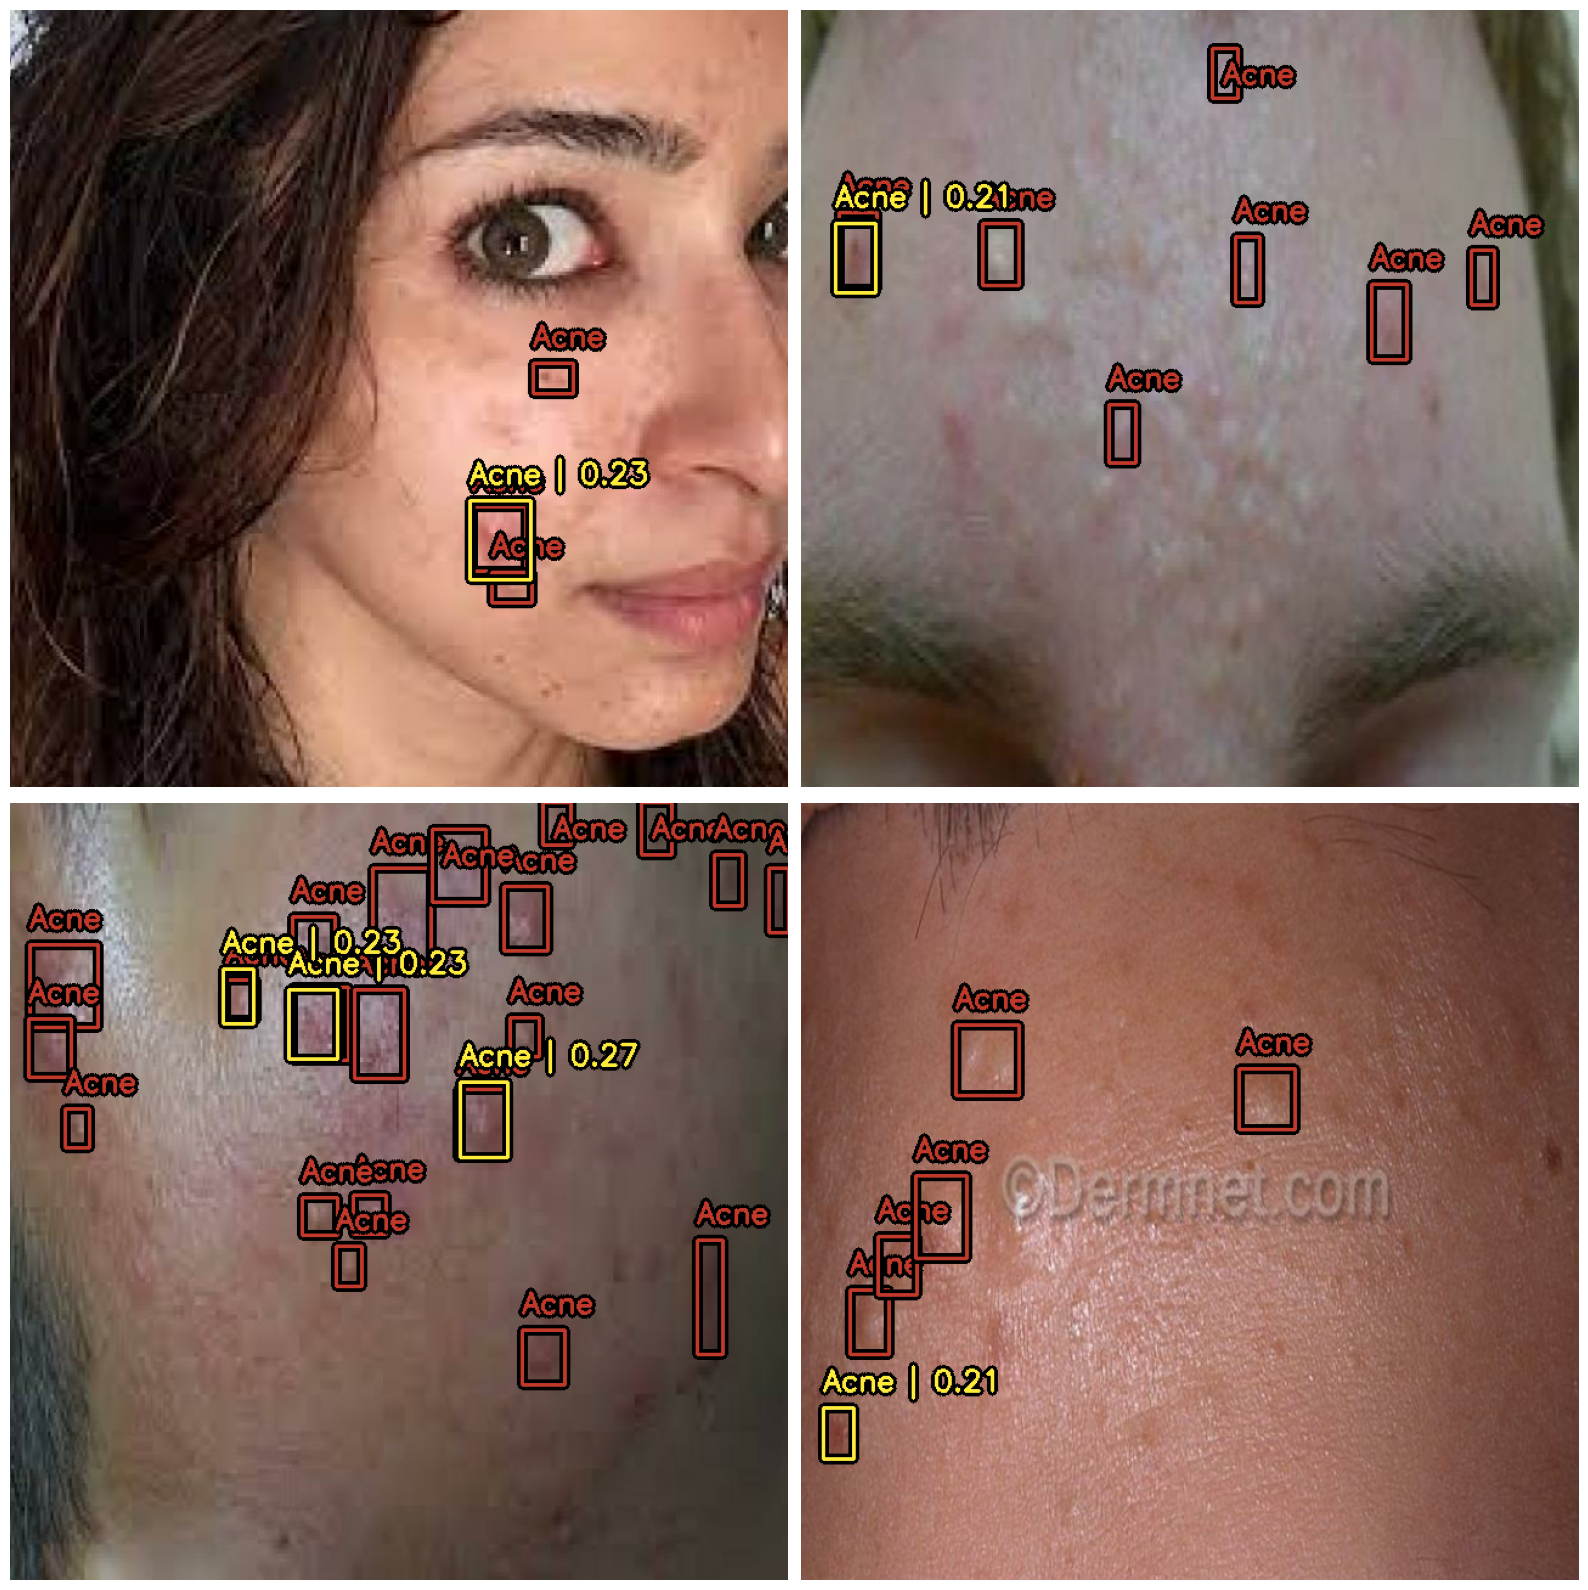

In [ ]:
# red -> ground true
# yellow -> prediction

YOLOV8_model.load_weights('/content/drive/MyDrive/yolo_model/yolo_acne_detection.h5')
visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")

In [ ]:
class_mapping = {0: 'Acne'} # 정수 인덱스르르 클래스 이름에 매핑, 딕셔너리 이용. 0 -> 여드름으로 인식
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)
# yolov8 모델설정. 생성된 백본과 추가 설정을 사용해 객체 탐지 모델 초기화. 클래스 수는 class_mapping 딕셔너리 길이를 기반. 바운딩 박스 포맷은 xyxy
YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping), bounding_box_format = "xyxy", backbone = backbone, fpn_depth = 5)

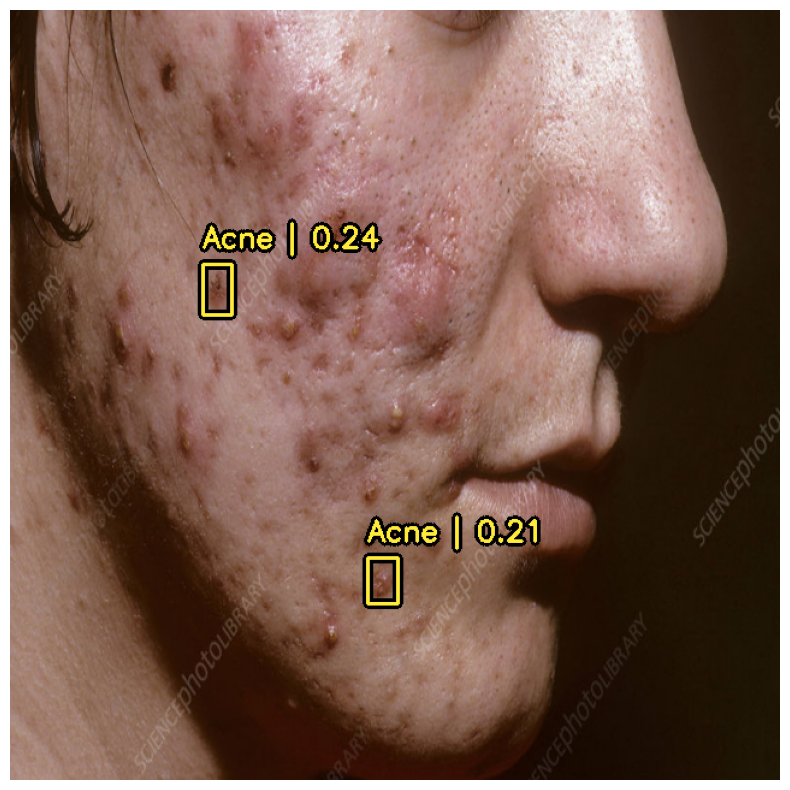

In [ ]:
import tensorflow as tf
import keras_cv

def visualize_single_image_prediction(model, img_path, bounding_box_format, class_mapping):
    # 이미지를 읽고 전처리
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (640, 640))  # 모델에 맞는 크기로 조정
    img = tf.expand_dims(img, axis=0)  # 배치 차원 추가

    # 모델 예측 수행
    y_pred = model.predict(img, verbose=0)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)  # 예측 결과를 RaggedTensor로 변환

    # 시각화
    keras_cv.visualization.plot_bounding_box_gallery(
        img,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=1,
        cols=1,
        show=True,
        class_mapping=class_mapping,
    )

# 예시 사용
# model: 이미 학습된 YOLOV8 모델
# 'path_to_your_image.jpg': 예측할 이미지 파일 경로
# 'xyxy': 바운딩 박스 포맷
# class_mapping: 클래스 ID와 이름을 매핑하는 사전
YOLOV8_model.load_weights('/content/drive/MyDrive/yolo_model/yolo_acne_detection.h5')
visualize_single_image_prediction(YOLOV8_model, '/content/drive/MyDrive/4.jpg', 'xyxy', class_mapping)


In [ ]:
import tensorflow as tf
import keras_cv

def visualize_single_image_prediction(model, img_path, bounding_box_format, class_mapping):
    # 이미지를 읽고 전처리
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (640, 640))  # 모델에 맞는 크기로 조정
    img = tf.expand_dims(img, axis=0)  # 배치 차원 추가

    # 모델 예측 수행
    y_pred = model.predict(img, verbose=0)
    print(y_pred)

# 예시 사용
# model: 이미 학습된 YOLOV8 모델
# 'xyxy': 바운딩 박스 포맷
# class_mapping: 클래스 ID와 이름을 매핑하는 사전
YOLOV8_model.load_weights('/content/drive/MyDrive/yolo_model/yolo_acne_detection.h5')
visualize_single_image_prediction(YOLOV8_model, '/content/drive/MyDrive/4.jpg', 'xyxy', class_mapping)


{'boxes': array([[[160.87909, 211.24724, 184.57927, 253.01315],
        [297.01862, 455.2525 , 322.2181 , 493.90176],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # 정규화
    img = tf.image.resize(img, [640, 640])  # 모델 입력 크기에 맞춤
    return img.numpy() # Eager Tensor를 NumPy 배열로 변환

def model_input(model, img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (640, 640))  # 모델에 맞는 크기로 조정
    img = tf.expand_dims(img, axis=0)  # 배치 차원 추가
    y_pred = model.predict(img, verbose=0)
    return y_pred

def visualize_predictions(img, result, save_path):
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)

    boxes = result['boxes'][0]  # 첫 번째 배치의 박스
    confidences = result['confidence'][0]  # 첫 번째 배치의 신뢰도
    class_ids = result['classes'][0]  # 첫 번째 배치의 클래스 ID

    boxes_total = 0
    for box, score, class_id in zip(boxes, confidences, class_ids):
        if score == -1:
            continue  # 유효하지 않은 박스는 건너뜁니다.
        boxes_total += 1
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = f'Score: {score:.2f}'
        ax.text(x1, y1, label, color='white', verticalalignment='top', bbox={'color': 'red', 'pad': 0})
    print(boxes_total)
    plt.axis('off')  # 축 표시 제거
    plt.savefig(save_path, bbox_inches='tight')  # 이미지 파일로 저장
    # plt.show()
    plt.close(fig)

# 이미지 로드 및 전처리
img_path = '/content/drive/MyDrive/4.jpg'
img = load_and_preprocess_image(img_path)

YOLOV8_model.load_weights('/content/drive/MyDrive/yolo_model/yolo_acne_detection.h5')
y = model_input(YOLOV8_model, img_path)

save_path = '/content/drive/MyDrive/detected_image.jpg'

# 시각화 실행
visualize_predictions(img, y, save_path)


2
